# Image Pre-processing

In this notebook we will show you how to denoise medical images and how to correct bias field inhomogeneities that can occur in MRI images.

But first we need install the required libraries to more easily perform these image pre-processing steps

## Check Environment and Install required libraries to execute notebooks

In this notebook, we will mainly rely on a library called SimpleITK.

In [1]:
!python -c "import SimpleITK" || pip install --upgrade --pre SimpleITK --find-links https://github.com/SimpleITK/SimpleITK/releases/tag/latest --progress-bar off -q
!python -c "import matplotlib" || pip install --progress-bar off -q matplotlib
%matplotlib inline

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'SimpleITK'

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


### Download example data from https://github.com/rcuocolo/PROSTATEx_masks repository

For simplicity, we will show you how to denoise and correct the bias field inhomogeneities on a single MRI image volume. We will download the image using the following code.

# Import required libraries

As previously said, we will use python libraries to facilitate our job executing each of the pre-processing steps.



In [2]:
import SimpleITK as sitk
import matplotlib.pyplot as plt

# Read example T2-weighted prostate MRI corresponding to case ID ProstateX-0010

We will use SimpleITK and matplotlib.pyplot to display some slices of the prostate MRI T2-weighted scan to read the image.



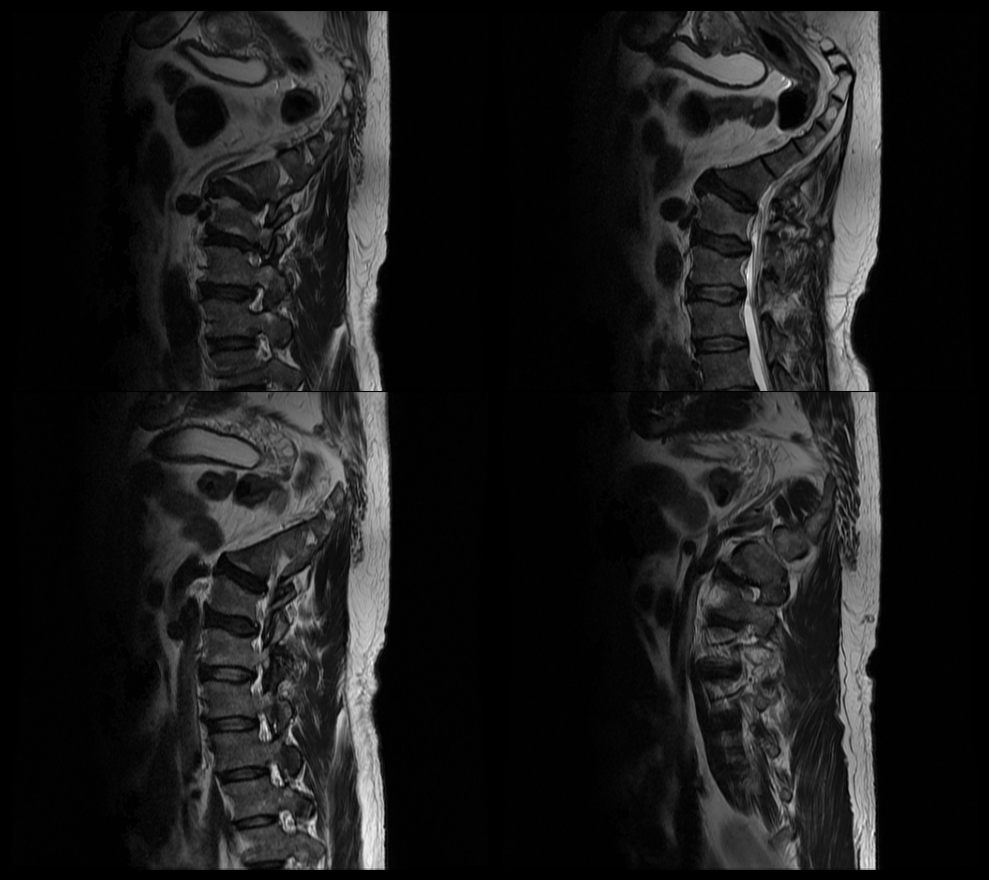

In [3]:
# the following line reads the prostate MRI image (3D volume) and assigns it to the variable image
image = sitk.ReadImage('/mnt/datalake/openmind/Midas/datasets/Midas_V0_merge_dep_fixed/MIDASds01/sub-S0017877/ses-E0019227/mim-mr/anat/sub-S0017877_ses-E0019227_run-1_bp-lsspine_vp-sag_T2w.nii.gz')

# select a couple of slices to display
fig, axes = plt.subplots (nrows = 2, ncols = 2, figsize = (10, 10))
rect = fig.patch
rect.set_facecolor('black')

axes[0,0].imshow(sitk.GetArrayFromImage(image)[3,:,:], cmap='gray')
axes[0,1].imshow(sitk.GetArrayFromImage(image)[5,:,:], cmap='gray')
axes[1,0].imshow(sitk.GetArrayFromImage(image)[8,:,:], cmap='gray')
axes[1,1].imshow(sitk.GetArrayFromImage(image)[10,:,:], cmap='gray')
# axes[1,1].imshow(sitk.GetArrayFromImage(image)[12,:,:], cmap='gray')
# axes[1,2].imshow(sitk.GetArrayFromImage(image)[14,:,:], cmap='gray')

for ax in axes.flat:
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
fig.tight_layout(h_pad=-15, w_pad=1)

In [4]:
image.GetSize()

(512, 512, 12)

As can be seen there are low-frequency and very smooth drifts in intensity within tissues that should have more or less the same intensity. Inhomogeneities in the scanner magnetic field cause these drifts.

### Create copy of image in float 32-bits

Originally our image was saved in 16-bits. This means that each voxel in the image has a depth of information that can occupy 16-bits.

To not lose information, some filters we will use require us to input 32-bits float images to avoid the loss of precision in their internal operations, and therefore the output.

But don't worry! Going from 16-bits to 32-bits (lower to higher bit depth) is very easy. You can use the following function to that.



In [7]:
# cast image voxel bit depth to 32-bits
image_float32 = sitk.Cast(image,sitk.sitkFloat32)

You may be asking what about going from higher to lower bit depth. This procedure requires additional steps to ensure that this is done properly, as shown in **Appendix 1 - which you can visit and test later**.  

Now that we have introduced a required preparation of images to execute some filters, we may want to correct some of the artifacts that affect medical images.

Medical images may be affected by:
- Motion artifacts
- Noise
- MRI bias field inhomogeneities
- Others

Let's try to start by correcting the bias field inhomogeneities artifacts.

# Bias field inhomogeneities correction

We will now try to correct these bias field inhomogeneities in our image using the following widely used function.

This filter takes a bit running (in the meantime, if you want to understand the causes of these inhomogeneities, you can read the comment and visit the link to learn more).

[Documentation of N4 Bias Field Correction filter](https://simpleitk.org/doxygen/latest/html/classitk_1_1simple_1_1N4BiasFieldCorrectionImageFilter.html)



In [9]:
# to speed up the process (~4 min to ~3 s) and because the bias field inhomogeneities is a slow drift in the image intensity we can downsample/downsize the image to find the bias field and then correct this on a larger image
shrinkFactor = 4
shrinked_image = sitk.Shrink(image_float32, [shrinkFactor] * image_float32.GetDimension())

# instantiate the filter and set options to execute with our image
bias_field_filter = sitk.N4BiasFieldCorrectionImageFilter()
bias_field_filter.SetNumberOfControlPoints([4,4,4])
bias_field_filter.UseMaskLabelOff()
# execute filter to determine the bias field
corrected_shrinked_image = bias_field_filter.Execute(shrinked_image)

# apply correction to original size image
log_bias_field = bias_field_filter.GetLogBiasFieldAsImage(image_float32)
bias_corrected_image = image_float32 / sitk.Exp(log_bias_field)

Plot the same slices as before and on the side the bias field inhomogeneities corrected images

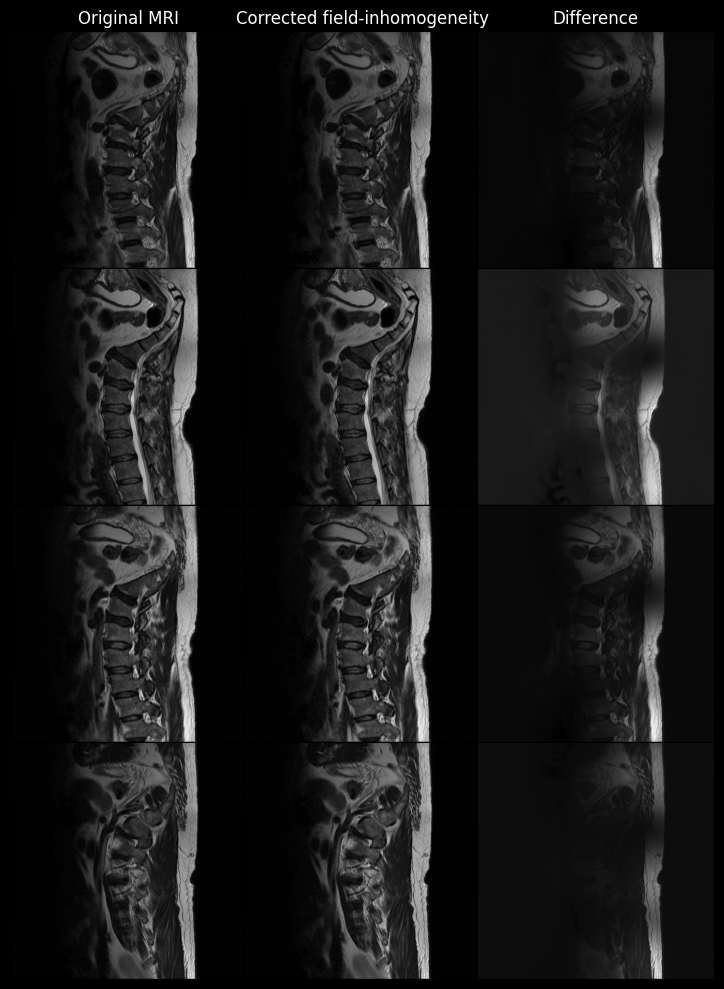

In [10]:
fig, axes = plt.subplots (nrows = 4, ncols = 3, figsize = (10, 10))
rect = fig.patch
rect.set_facecolor('black')

axes[0,0].imshow(sitk.GetArrayFromImage(image)[3,:,:], cmap='gray')
axes[0,1].imshow(sitk.GetArrayFromImage(bias_corrected_image)[3,:,:], cmap='gray')
axes[0,2].imshow(sitk.GetArrayFromImage(-bias_corrected_image)[3,:,:]+sitk.GetArrayFromImage(image)[3,:,:], cmap='gray')
axes[0,0].set_title('Original MRI', color='w')
axes[0,1].set_title('Corrected field-inhomogeneity', color='w')
axes[0,2].set_title('Difference', color='w')
axes[1,0].imshow(sitk.GetArrayFromImage(image)[5,:,:], cmap='gray')
axes[1,1].imshow(sitk.GetArrayFromImage(bias_corrected_image)[5,:,:], cmap='gray')
axes[1,2].imshow(sitk.GetArrayFromImage(-bias_corrected_image)[5,:,:]+sitk.GetArrayFromImage(image)[5,:,:], cmap='gray')
axes[2,0].imshow(sitk.GetArrayFromImage(image)[8,:,:], cmap='gray')
axes[2,1].imshow(sitk.GetArrayFromImage(bias_corrected_image)[8,:,:], cmap='gray')
axes[2,2].imshow(sitk.GetArrayFromImage(-bias_corrected_image)[8,:,:]+sitk.GetArrayFromImage(image)[8,:,:], cmap='gray')
axes[3,0].imshow(sitk.GetArrayFromImage(image)[10,:,:], cmap='gray')
axes[3,1].imshow(sitk.GetArrayFromImage(bias_corrected_image)[10,:,:], cmap='gray')
axes[3,2].imshow(sitk.GetArrayFromImage(-bias_corrected_image)[10,:,:]+sitk.GetArrayFromImage(image)[10,:,:], cmap='gray')
# axes[4,0].imshow(sitk.GetArrayFromImage(image)[12,:,:], cmap='gray')
# axes[4,1].imshow(sitk.GetArrayFromImage(bias_corrected_image)[12,:,:], cmap='gray')
# axes[4,2].imshow(sitk.GetArrayFromImage(-bias_corrected_image)[12,:,:]+sitk.GetArrayFromImage(image)[12,:,:], cmap='gray')
# axes[5,0].imshow(sitk.GetArrayFromImage(image)[14,:,:], cmap='gray')
# axes[5,1].imshow(sitk.GetArrayFromImage(bias_corrected_image)[14,:,:], cmap='gray')
# axes[5,2].imshow(sitk.GetArrayFromImage(-bias_corrected_image)[14,:,:]+sitk.GetArrayFromImage(image)[14,:,:], cmap='gray')

for ax in axes.flat:
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
fig.tight_layout(h_pad=0, w_pad=-15)

Now let's try to denoise the bias corrected image.

# Denoising MRI

Medical images can be affected by several types of noise. It is possible to use the noise type information to apply specific denoising filters properly developed for such noise types.

However, in most cases, images may not be affected by a single type of noise. While we wish to remove the noise, we do not want to lose the details of fine structures; therefore, a common class of filters used are the edge-preserving denoising filters.

In medical image pre-processing, a common type of denoising filters used are the anisotropic diffusion-based filters (e.g., Gradient Anisotropic Diffusion and Curvature Anisotropic Diffusion).

In this case, we will use the Curvature Anisotropic Diffusion as it compares with other non-linear diffusion techniques and, in comparison with the Gradient Anisotropic Diffusion, can better preserve finer detailed structures due to its less sensitivity to contrast.

In Appendix 2, we show how you can execute the Gradient Anisotropic Diffusion filter, and we compare its output with the one from Curvature Anisotropic Diffusion.

[Documentation of Curvature Anisotropic Diffusion filter](https://simpleitk.org/doxygen/latest/html/classitk_1_1simple_1_1CurvatureAnisotropicDiffusionImageFilter.html)

[Documentation of Gradient Anisotropic Diffusion filter](https://simpleitk.org/doxygen/latest/html/classitk_1_1simple_1_1GradientAnisotropicDiffusionImageFilter.html)


In [11]:
denoised_image = sitk.CurvatureAnisotropicDiffusion(bias_corrected_image,timeStep=0.03125)

Plot the bias corrected image, the **denoised** bias corrected image, and the difference between the two

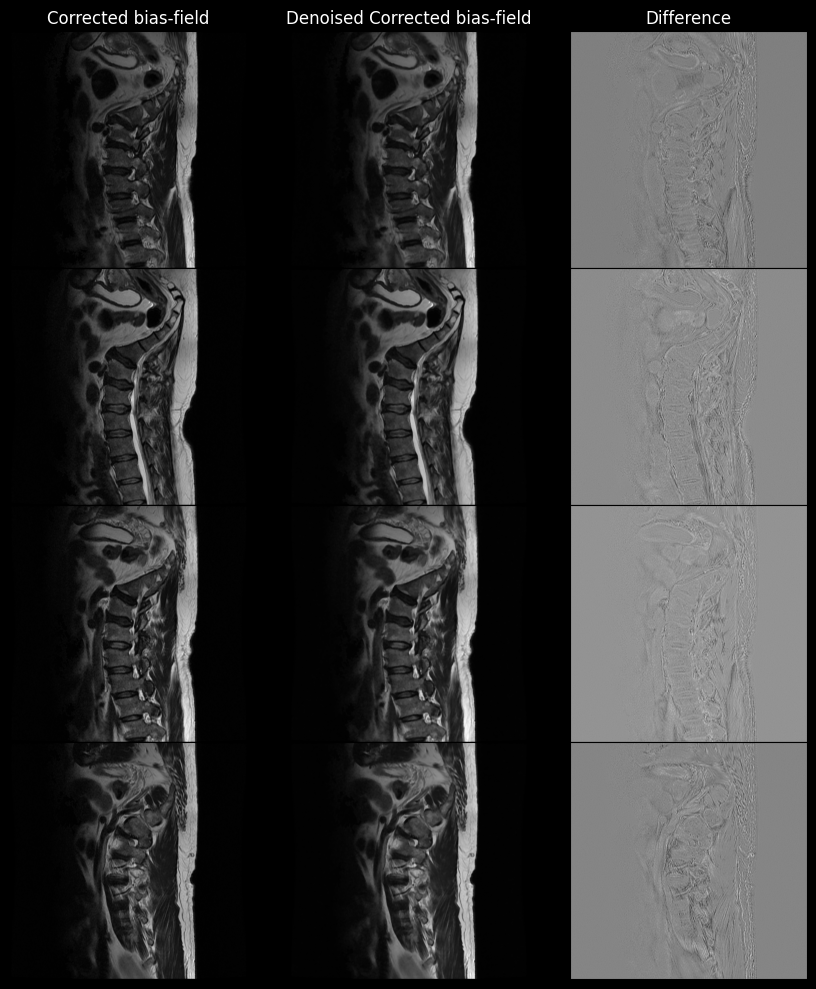

In [14]:
fig, axes = plt.subplots (nrows = 4, ncols = 3, figsize = (10, 10))
rect = fig.patch
rect.set_facecolor('black')

axes[0,0].imshow(sitk.GetArrayFromImage(bias_corrected_image)[3,:,:], cmap='gray')
axes[0,1].imshow(sitk.GetArrayFromImage(denoised_image)[3,:,:], cmap='gray')
axes[0,2].imshow(sitk.GetArrayFromImage(denoised_image)[3,:,:]-sitk.GetArrayFromImage(bias_corrected_image)[3,:,:], cmap='gray')
axes[0,0].set_title('Corrected bias-field', color='w')
axes[0,1].set_title('Denoised Corrected bias-field', color='w')
axes[0,2].set_title('Difference', color='w')
axes[1,0].imshow(sitk.GetArrayFromImage(bias_corrected_image)[5,:,:], cmap='gray')
axes[1,1].imshow(sitk.GetArrayFromImage(denoised_image)[5,:,:], cmap='gray')
axes[1,2].imshow(sitk.GetArrayFromImage(denoised_image)[5,:,:]-sitk.GetArrayFromImage(bias_corrected_image)[5,:,:], cmap='gray')
axes[2,0].imshow(sitk.GetArrayFromImage(bias_corrected_image)[8,:,:], cmap='gray')
axes[2,1].imshow(sitk.GetArrayFromImage(denoised_image)[8,:,:], cmap='gray')
axes[2,2].imshow(sitk.GetArrayFromImage(denoised_image)[8,:,:]-sitk.GetArrayFromImage(bias_corrected_image)[8,:,:], cmap='gray')
axes[3,0].imshow(sitk.GetArrayFromImage(bias_corrected_image)[10,:,:], cmap='gray')
axes[3,1].imshow(sitk.GetArrayFromImage(denoised_image)[10,:,:], cmap='gray')
axes[3,2].imshow(sitk.GetArrayFromImage(denoised_image)[10,:,:]-sitk.GetArrayFromImage(bias_corrected_image)[10,:,:], cmap='gray')
#axes[4,0].imshow(sitk.GetArrayFromImage(bias_corrected_image)[12,:,:], cmap='gray')
#axes[4,1].imshow(sitk.GetArrayFromImage(denoised_image)[12,:,:], cmap='gray')
#axes[4,2].imshow(sitk.GetArrayFromImage(denoised_image)[12,:,:]-sitk.GetArrayFromImage(bias_corrected_image)[12,:,:], cmap='gray')
#axes[5,0].imshow(sitk.GetArrayFromImage(bias_corrected_image)[14,:,:], cmap='gray')
#axes[5,1].imshow(sitk.GetArrayFromImage(denoised_image)[14,:,:], cmap='gray')
#axes[5,2].imshow(sitk.GetArrayFromImage(denoised_image)[14,:,:]-sitk.GetArrayFromImage(bias_corrected_image)[14,:,:], cmap='gray')

for ax in axes.flat:
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
fig.tight_layout(h_pad=0, w_pad=-5)

# Appendix 1 - Casting and Image bit depth

## **Casting images from higher bit depth to lower bit depth**

To perform this operation, we have to consider the maximum value of the desired bit depth.

* unsigned 8-bits (UInt8) - ranges from 0 to 255
* signed 8-bits (Int8) - ranges from -127 to 127
* unsigned 16-bits (UInt16) - ranges from 0 to 65535
* signed 16-bits (Int16) - ranges from -32768 to 32767
* ... and so on.

So imagine that we have an UInt16 image that we want to cast to UInt8.

If we just cast the 16-bits image to 8-bits we may lose information. Let's try it

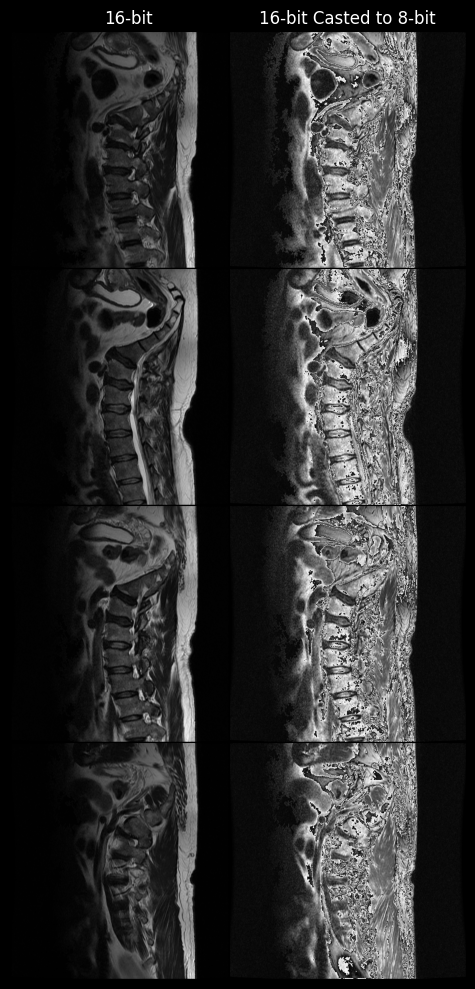

In [22]:
# perform casting of 16-bits image to 8-bits
image_16b_to_8b = sitk.Cast(image, sitk.sitkUInt8)

# plot 16-bit and 8-bit image casted from 16-bit without preparation
fig, axes = plt.subplots (nrows = 4, ncols = 2, figsize = (10, 10))
rect = fig.patch
rect.set_facecolor('black')

axes[0,0].imshow(sitk.GetArrayFromImage(image)[3,:,:], cmap='gray')
axes[0,1].imshow(sitk.GetArrayFromImage(image_16b_to_8b)[3,:,:], cmap='gray')
axes[0,0].set_title('16-bit', color='w')
axes[0,1].set_title('16-bit Casted to 8-bit', color='w')
axes[1,0].imshow(sitk.GetArrayFromImage(image)[5,:,:], cmap='gray')
axes[1,1].imshow(sitk.GetArrayFromImage(image_16b_to_8b)[5,:,:], cmap='gray')
axes[2,0].imshow(sitk.GetArrayFromImage(image)[8,:,:], cmap='gray')
axes[2,1].imshow(sitk.GetArrayFromImage(image_16b_to_8b)[8,:,:], cmap='gray')
axes[3,0].imshow(sitk.GetArrayFromImage(image)[10,:,:], cmap='gray')
axes[3,1].imshow(sitk.GetArrayFromImage(image_16b_to_8b)[10,:,:], cmap='gray')
# axes[4,0].imshow(sitk.GetArrayFromImage(image)[12,:,:], cmap='gray')
# axes[4,1].imshow(sitk.GetArrayFromImage(image_16b_to_8b)[12,:,:], cmap='gray')
# axes[5,0].imshow(sitk.GetArrayFromImage(image)[14,:,:], cmap='gray')
# axes[5,1].imshow(sitk.GetArrayFromImage(image_16b_to_8b)[14,:,:], cmap='gray')

for ax in axes.flat:
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
fig.tight_layout(h_pad=0, w_pad=-25)

To correctly cast an image from a higher to a lower bit depth, we need to rescale the image intensities to ensure all the intensities can be depicted in this lower bit depth.

This rescaling may cause some loss of information but considerably less than a simple casting, as you will see in the next example.

In [15]:
# rescale image intensities to be within unsigned 8-bit depth (0-255)
rescaled_image = sitk.RescaleIntensity(image, outputMinimum=0, outputMaximum=255)
image_16b_to_8b = sitk.Cast(rescaled_image, sitk.sitkUInt8)

Let's now visualize the original 16-bit and the rescaled casted to 8-bit depth image

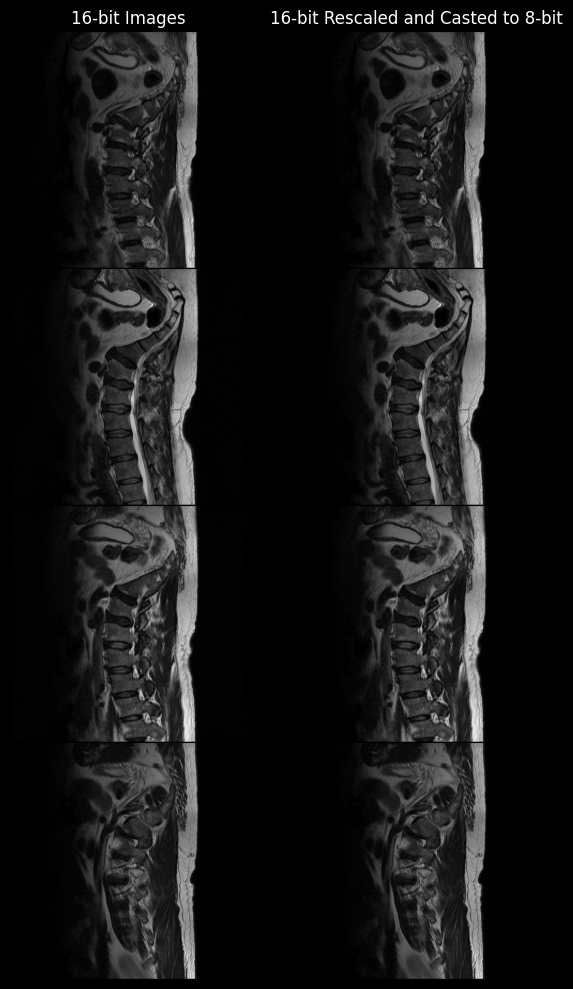

In [18]:
fig, axes = plt.subplots (nrows = 4, ncols = 2, figsize = (10, 10))
rect = fig.patch
rect.set_facecolor('black')

axes[0,0].imshow(sitk.GetArrayFromImage(image)[3,:,:], cmap='gray')
axes[0,1].imshow(sitk.GetArrayFromImage(image_16b_to_8b)[3,:,:], cmap='gray')
axes[0,0].set_title('16-bit Images', color='w')
axes[0,1].set_title('16-bit Rescaled and Casted to 8-bit', color='w')
axes[1,0].imshow(sitk.GetArrayFromImage(image)[5,:,:], cmap='gray')
axes[1,1].imshow(sitk.GetArrayFromImage(image_16b_to_8b)[5,:,:], cmap='gray')
axes[2,0].imshow(sitk.GetArrayFromImage(image)[8,:,:], cmap='gray')
axes[2,1].imshow(sitk.GetArrayFromImage(image_16b_to_8b)[8,:,:], cmap='gray')
axes[3,0].imshow(sitk.GetArrayFromImage(image)[10,:,:], cmap='gray')
axes[3,1].imshow(sitk.GetArrayFromImage(image_16b_to_8b)[10,:,:], cmap='gray')
# axes[4,0].imshow(sitk.GetArrayFromImage(image)[12,:,:], cmap='gray')
# axes[4,1].imshow(sitk.GetArrayFromImage(image_16b_to_8b)[12,:,:], cmap='gray')
# axes[5,0].imshow(sitk.GetArrayFromImage(image)[14,:,:], cmap='gray')
# axes[5,1].imshow(sitk.GetArrayFromImage(image_16b_to_8b)[14,:,:], cmap='gray')

for ax in axes.flat:
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
fig.tight_layout(h_pad=0, w_pad=-15)

# Appendix 2 - Comparison betwenn Curvature and Gradient Anisotropic Diffusion filter

Let's filter the bias field corrected image using the Gradient Anisotropic Diffusion filter.


In [17]:
denoised_grad_ani_dif_image = sitk.GradientAnisotropicDiffusion(bias_corrected_image)

GradientAnisotropicDiffusionImageFilter (0x321b890): Anisotropic diffusion unstable time step: 0.125
Stable time step for this image must be smaller than 0.0402829

GradientAnisotropicDiffusionImageFilter (0x321b890): Anisotropic diffusion unstable time step: 0.125
Stable time step for this image must be smaller than 0.0402829

GradientAnisotropicDiffusionImageFilter (0x321b890): Anisotropic diffusion unstable time step: 0.125
Stable time step for this image must be smaller than 0.0402829

GradientAnisotropicDiffusionImageFilter (0x321b890): Anisotropic diffusion unstable time step: 0.125
Stable time step for this image must be smaller than 0.0402829

GradientAnisotropicDiffusionImageFilter (0x321b890): Anisotropic diffusion unstable time step: 0.125
Stable time step for this image must be smaller than 0.0402829



Let's plot the filtered images and difference to compare.

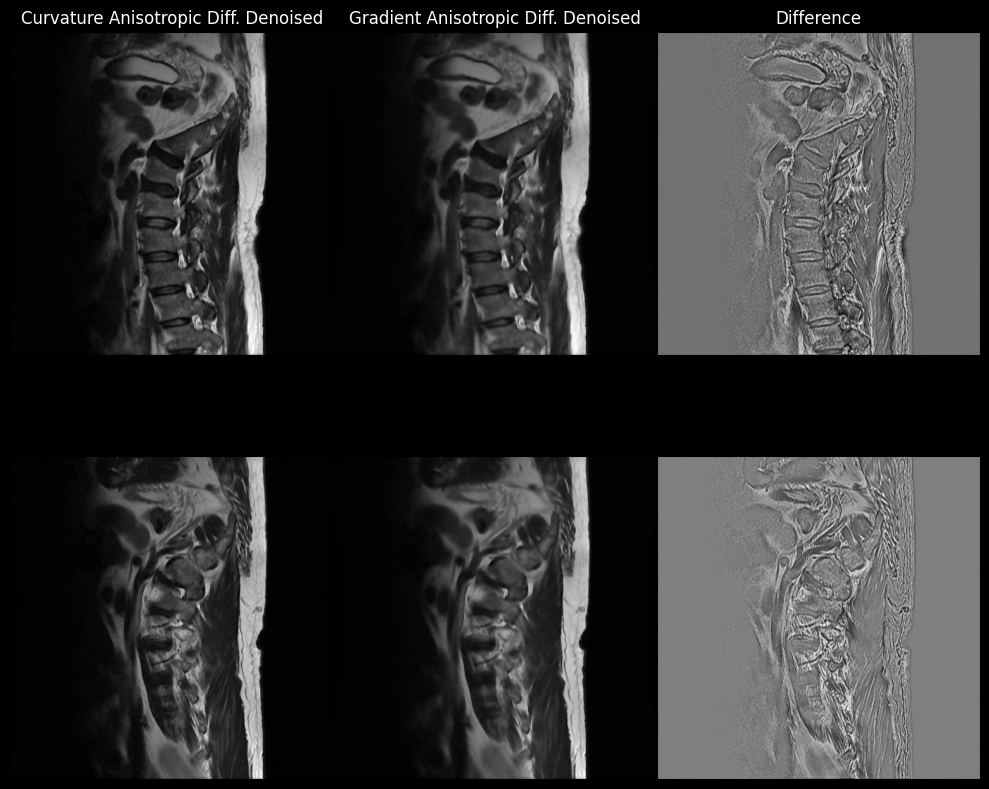

In [20]:
fig, axes = plt.subplots (nrows = 2, ncols = 3, figsize = (10, 10))
rect = fig.patch
rect.set_facecolor('black')

axes[0,0].imshow(sitk.GetArrayFromImage(denoised_image)[8,:,:], cmap='gray')
axes[0,1].imshow(sitk.GetArrayFromImage(denoised_grad_ani_dif_image)[8,:,:], cmap='gray')
axes[0,2].imshow(sitk.GetArrayFromImage(denoised_image)[8,:,:]-sitk.GetArrayFromImage(denoised_grad_ani_dif_image)[8,:,:], cmap='gray')
axes[0,0].set_title('Curvature Anisotropic Diff. Denoised', color='w')
axes[0,1].set_title('Gradient Anisotropic Diff. Denoised', color='w')
axes[0,2].set_title('Difference', color='w')
axes[1,0].imshow(sitk.GetArrayFromImage(denoised_image)[10,:,:], cmap='gray')
axes[1,1].imshow(sitk.GetArrayFromImage(denoised_grad_ani_dif_image)[10,:,:], cmap='gray')
axes[1,2].imshow(sitk.GetArrayFromImage(denoised_image)[10,:,:]-sitk.GetArrayFromImage(denoised_grad_ani_dif_image)[10,:,:], cmap='gray')
# axes[2,0].imshow(sitk.GetArrayFromImage(denoised_image)[12,:,:], cmap='gray')
# axes[2,1].imshow(sitk.GetArrayFromImage(denoised_grad_ani_dif_image)[12,:,:], cmap='gray')
# axes[2,2].imshow(sitk.GetArrayFromImage(denoised_image)[12,:,:]-sitk.GetArrayFromImage(denoised_grad_ani_dif_image)[12,:,:], cmap='gray')

for ax in axes.flat:
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
fig.tight_layout(h_pad=0, w_pad=0)

As you can see the image on the left (denoised with Curvature Anisotropic Diffusion filtering) more clearly depicts edges than the image on the right (denoised with Gradient Anisotropic Diffusion filtering).

# Additional example with added Gaussian noise to better observe the efect of the denoising algorithm

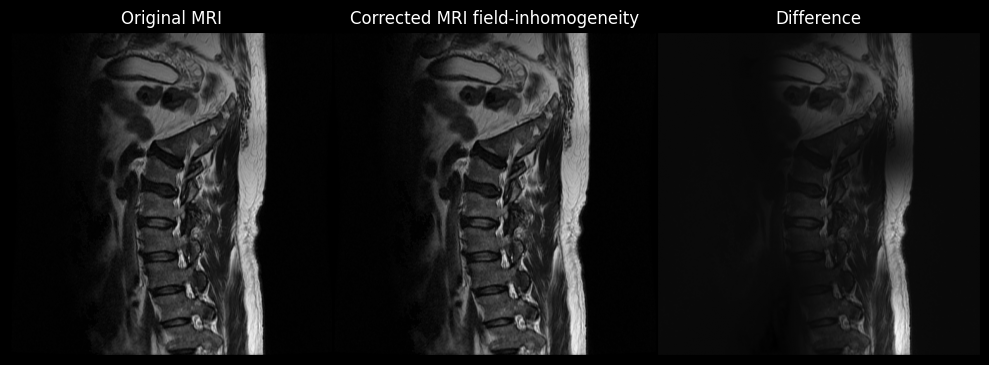

In [23]:
# Plot the same slices as before and on the side the bias field inhomogeneities corrected images
fig, axes = plt.subplots (nrows = 1, ncols = 3, figsize = (10, 10))
rect = fig.patch
rect.set_facecolor('black')

axes[0].imshow(sitk.GetArrayFromImage(image)[8,:,:], cmap='gray')
axes[1].imshow(sitk.GetArrayFromImage(bias_corrected_image)[8,:,:], cmap='gray')
axes[2].imshow(sitk.GetArrayFromImage(-bias_corrected_image)[8,:,:]+sitk.GetArrayFromImage(image)[8,:,:], cmap='gray')
axes[0].set_title('Original MRI', color='w')
axes[1].set_title('Corrected MRI field-inhomogeneity', color='w')
axes[2].set_title('Difference', color='w')

for ax in axes.flat:
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
fig.tight_layout(h_pad=0, w_pad=0)

CurvatureAnisotropicDiffusionImageFilter (0x3419950): Anisotropic diffusion unstable time step: 0.0625
Stable time step for this image must be smaller than 0.0402829

CurvatureAnisotropicDiffusionImageFilter (0x3419950): Anisotropic diffusion unstable time step: 0.0625
Stable time step for this image must be smaller than 0.0402829

CurvatureAnisotropicDiffusionImageFilter (0x3419950): Anisotropic diffusion unstable time step: 0.0625
Stable time step for this image must be smaller than 0.0402829

CurvatureAnisotropicDiffusionImageFilter (0x3419950): Anisotropic diffusion unstable time step: 0.0625
Stable time step for this image must be smaller than 0.0402829

CurvatureAnisotropicDiffusionImageFilter (0x3419950): Anisotropic diffusion unstable time step: 0.0625
Stable time step for this image must be smaller than 0.0402829



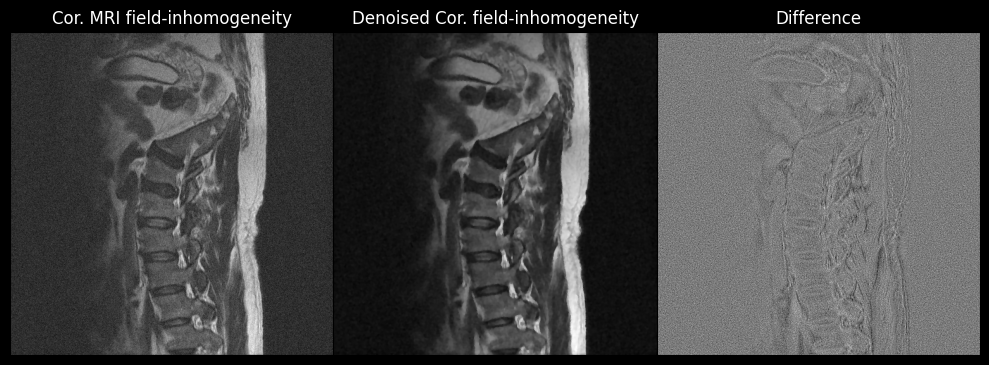

In [24]:
# Plot the same slices as before and on the side the bias field inhomogeneities corrected images
fig, axes = plt.subplots (nrows = 1, ncols = 3, figsize = (10, 10))
rect = fig.patch
rect.set_facecolor('black')
noisy = sitk.AdditiveGaussianNoise(bias_corrected_image, 50)
denoised_noisy_image = sitk.CurvatureAnisotropicDiffusion(noisy)
axes[0].imshow(sitk.GetArrayFromImage(noisy)[8,:,:], cmap='gray')
axes[1].imshow(sitk.GetArrayFromImage(denoised_noisy_image)[8,:,:], cmap='gray')
axes[2].imshow(sitk.GetArrayFromImage(denoised_noisy_image)[8,:,:]-sitk.GetArrayFromImage(noisy)[8,:,:], cmap='gray')
axes[0].set_title('Cor. MRI field-inhomogeneity', color='w')
axes[1].set_title('Denoised Cor. field-inhomogeneity', color='w')
axes[2].set_title('Difference', color='w')

for ax in axes.flat:
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
fig.tight_layout(h_pad=0, w_pad=0)

